<a href="https://colab.research.google.com/github/alexlopespereira/mba_enap/blob/main/CD/Notebooks/Aula1_GraficosStoryTelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aula 1 - Gráficos com Seaborn e Story Telling


### Vamos estudar algumas (poucas) opções de configuração dos gráficos do Seaborn.

*   Remover Clutter
*   Adicionar Label aos eixos
*   Remover as bordas do gráfico
*   Ajustar a cor de fundo
*   Definir o intervalo numérico dos eixos
*   Definir os ticks dos eixos

Investiremos mais tempo adiquirindo habilidades de Storytelling no Data Studio e no Observable. Por que?


### Importar as bibliotecas

In [1]:
import numpy as np # Importar o numpy
import pandas as pd


### O dataset deste estudo de caso: [Aquecimento Global](https://data.giss.nasa.gov/gistemp/graphs_v3/)

In [109]:
# 1) O dataset que está em "https://data.giss.nasa.gov/gistemp/graphs_v3/graph_data/GISTEMP_Seasonal_Cycle_since_1880/graph.csv" (o dataset foi retirado do gráfico)
# Tambem disponibilizei aqui https://github.com/alexlopespereira/mba_enap/raw/refs/heads/main/data/originais/aquecimento_global/graph.csv

df = pd.read_csv("https://github.com/alexlopespereira/mba_enap/raw/refs/heads/main/data/originais/aquecimento_global/graph.csv", skiprows=1, dtype={"Year":str})


In [110]:
# 2) Fazer transformações necessárias nas colunas. Coloque o ano numa coluna e o mês em outra. O mês está num formato numérico que não coincide com nosso calendário.
df[['ano', 'mes']] = df['Year'].str.split('.', expand=True)
df['ano'] = df['ano'].astype(np.int64)
map_mes_abreviado = {'04': 'jan', '13': 'feb', '21': 'mar', '29': 'apr', '38': 'may', '46': 'jun', '54': 'jul', '63': 'aug', '71': 'sep', '79': 'oct', '88': 'nov', '96': 'dec'}
#map_mes = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

map_mes_num = {'04': 1, '13': 2, '21': 3, '29': 4, '38': 5, '46': 6, '54': 7, '63': 8, '71': 9, '79': 10, '88': 11, '96': 12}
df['mes_num'] = df['mes'].map(map_mes_num)

df['mes'] = df['mes'].map(map_mes_abreviado)
df['date'] = df[['ano', 'mes_num']].apply(lambda x: f"{x['ano']}-{x['mes_num']}-01", axis=1)
df['mes'] = pd.Categorical(df['mes'], ordered=True, categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
# del df['Year']
df.head()


,Year,Anomaly,ano,mes,mes_num,date
0,1880.04,-2.70,1880,jan,1,1880-1-01
1,1880.13,-2.33,1880,feb,2,1880-2-01
2,1880.21,-1.58,1880,mar,3,1880-3-01
3,1880.29,-0.67,1880,apr,4,1880-4-01
4,1880.38,0.35,1880,may,5,1880-5-01


### Sobre este assunto, existe uma bonita visualização de dados usando uma técnica chamada scrolltelling [aqui](https://www.bloomberg.com/graphics/2015-whats-warming-the-world/)

### Metadados para entender o dataset encontram-se disponíveis [aqui](https://data.giss.nasa.gov/gistemp/). O trecho de texto abaixo foi retirado desse link:
##### *The following are plain-text files in tabular format of temperature anomalies, i.e. deviations from the corresponding 1951-1980 means.*
*   *Global-mean monthly, seasonal, and annual means, 1880-present, updated through most recent month*

## Plotando um gráfico parecido com o plotnine
### Prompt: usando o plotnine, plote um grafico de linha com o ano no eixo x e a media da coluna Anomaly no eixo y. Use uma figura do tamanho 8x4 polegadas.


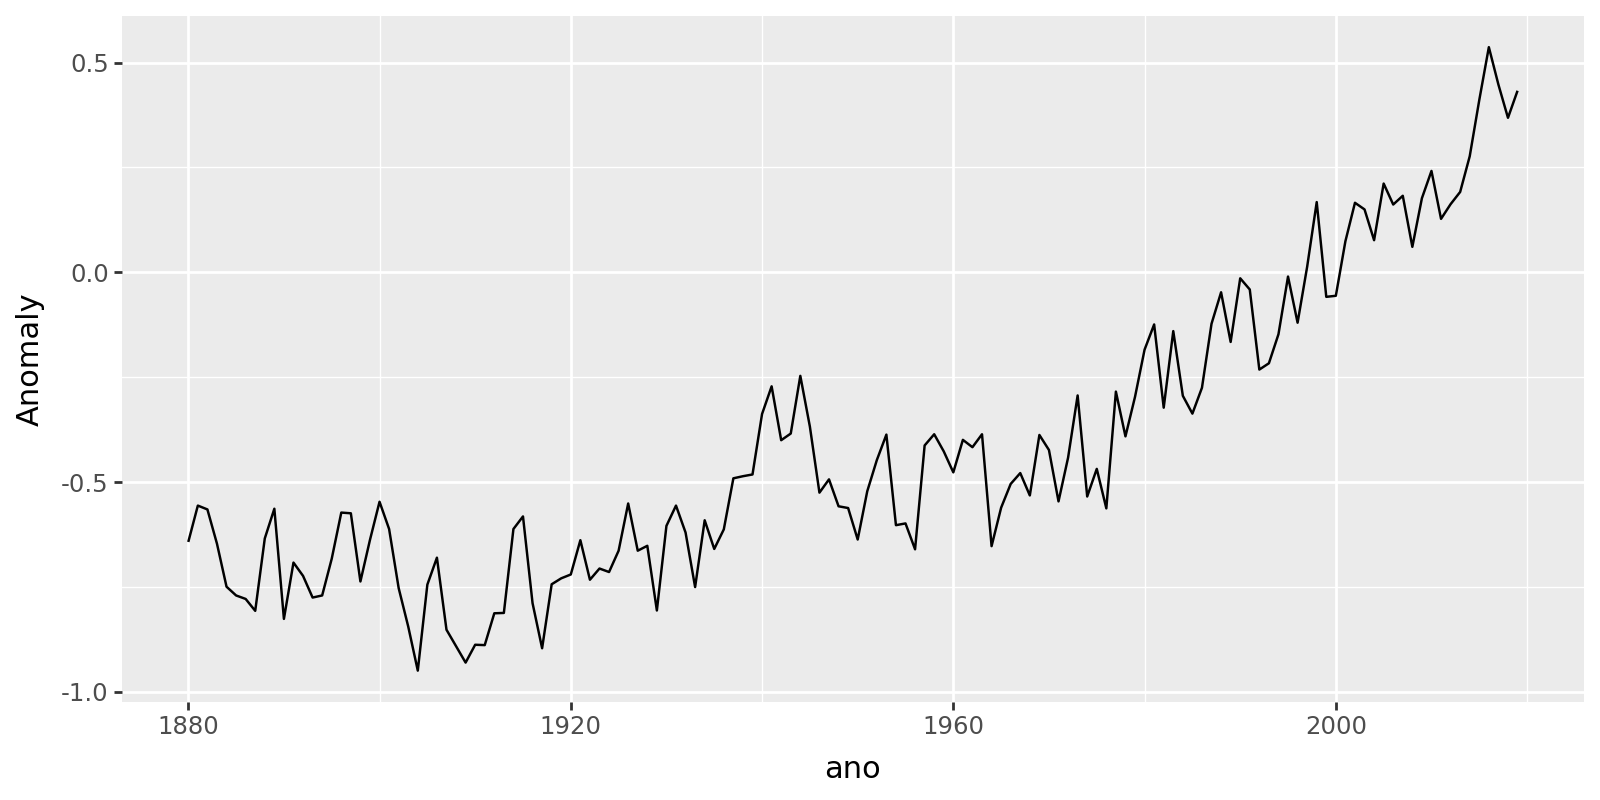

In [79]:
from plotnine import ggplot, aes, geom_line, theme
import numpy as np

(ggplot(df, aes(x='ano', y='Anomaly'))
 + geom_line(stat="summary", fun_y=np.mean)
 + theme(figure_size=(8, 4))
)

### Plotando o intervalo de confiança de 95%

### Prompt que fiz na perplexity:

nesse grafico: """\(ggplot(df, aes(x='ano', y='Anomaly'))
\+ geom_line(stat="summary", fun_y=np.mean)
\+ theme(aspect_ratio=1/2) # Adjust aspect ratio (height/width)
\)""" adicione um intervalo de confiança em torno da média representada pela linha do grafico

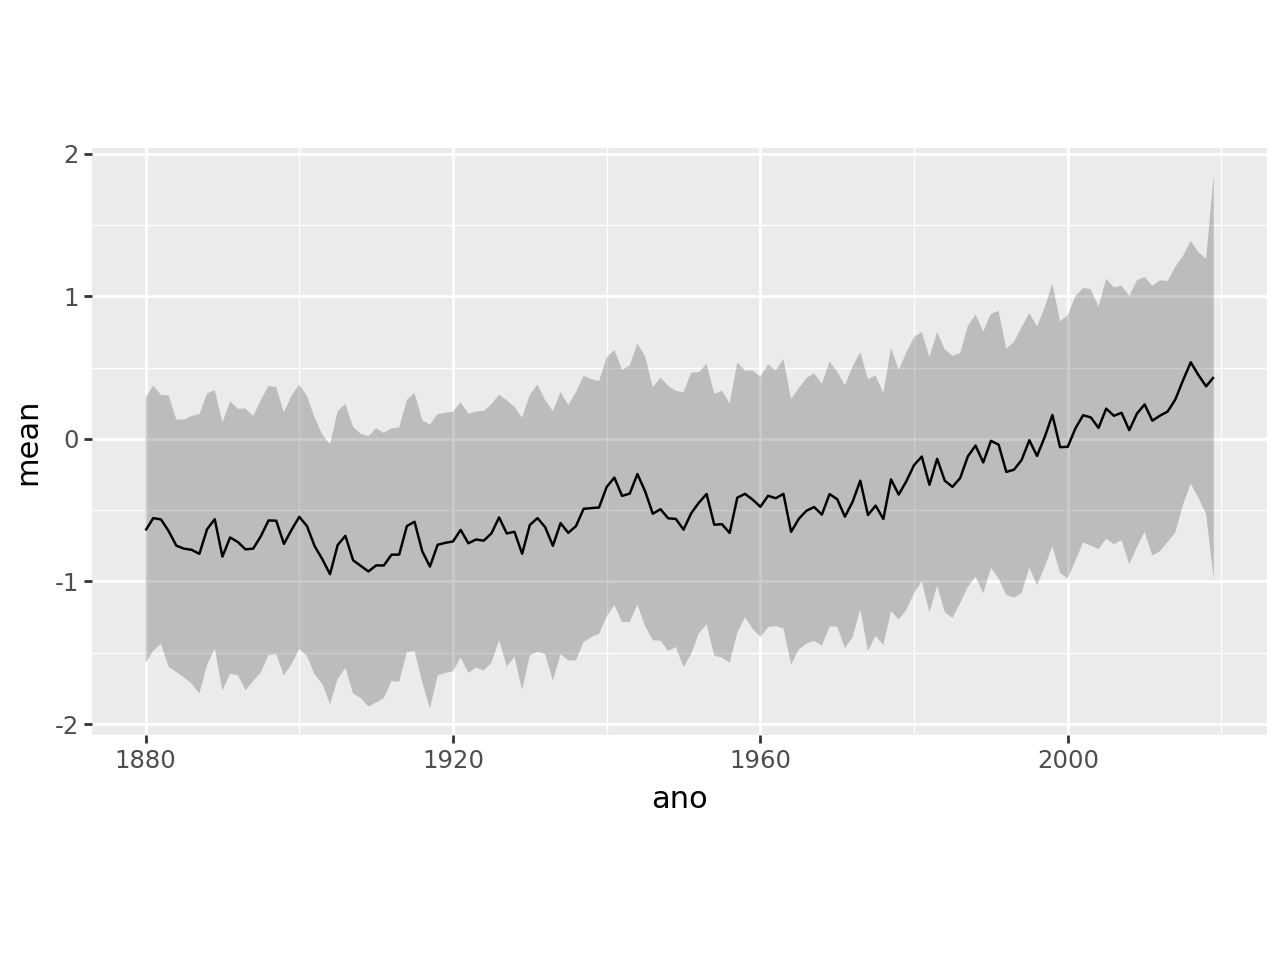

In [80]:
import numpy as np
import pandas as pd
from scipy import stats
from plotnine import ggplot, aes, geom_line, geom_ribbon, theme

# 1) Resumir por ano: média, desvio-padrão, n e IC95%
g = df.groupby('ano')['Anomaly']
summary = g.agg(mean='mean', sd='std', n='size').reset_index()
summary['se'] = summary['sd'] / np.sqrt(summary['n'])
# t crítico para 95% (bilateral) com n-1 graus de liberdade
summary['tcrit'] = stats.t.ppf(1-0.025, summary['n']-1)
summary['ci'] = summary['tcrit'] * summary['se']
summary['ymin'] = summary['mean'] - summary['ci']
summary['ymax'] = summary['mean'] + summary['ci']

# 2) Plot: faixa de IC + linha da média
p = (
    ggplot(summary, aes(x='ano', y='mean'))
    + geom_ribbon(aes(ymin='ymin', ymax='ymax'), alpha=0.25)  # IC95%
    + geom_line()                                             # média
    + theme(aspect_ratio=1/2)
)
p


## Vamos tentar reproduzir o gráfico a seguir.
### Disponível [aqui](https://data.giss.nasa.gov/gistemp/graphs_v3/).


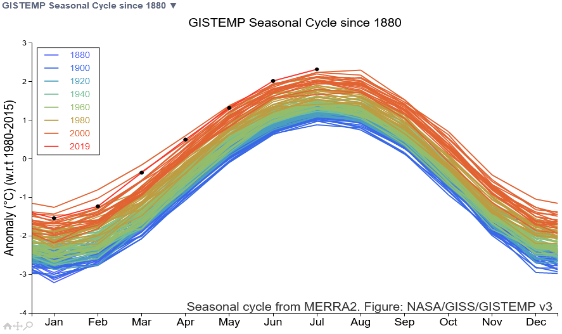

### Prompt: considerando o dataframe df, usando o plotnine, plote um grafico de linhas, com multiplas series. Onde cada série é representada por um ano. No eixo y plote o valor da coluna Anomaly, e no eixo x os meses do ano. Use o colormap coolwarm.

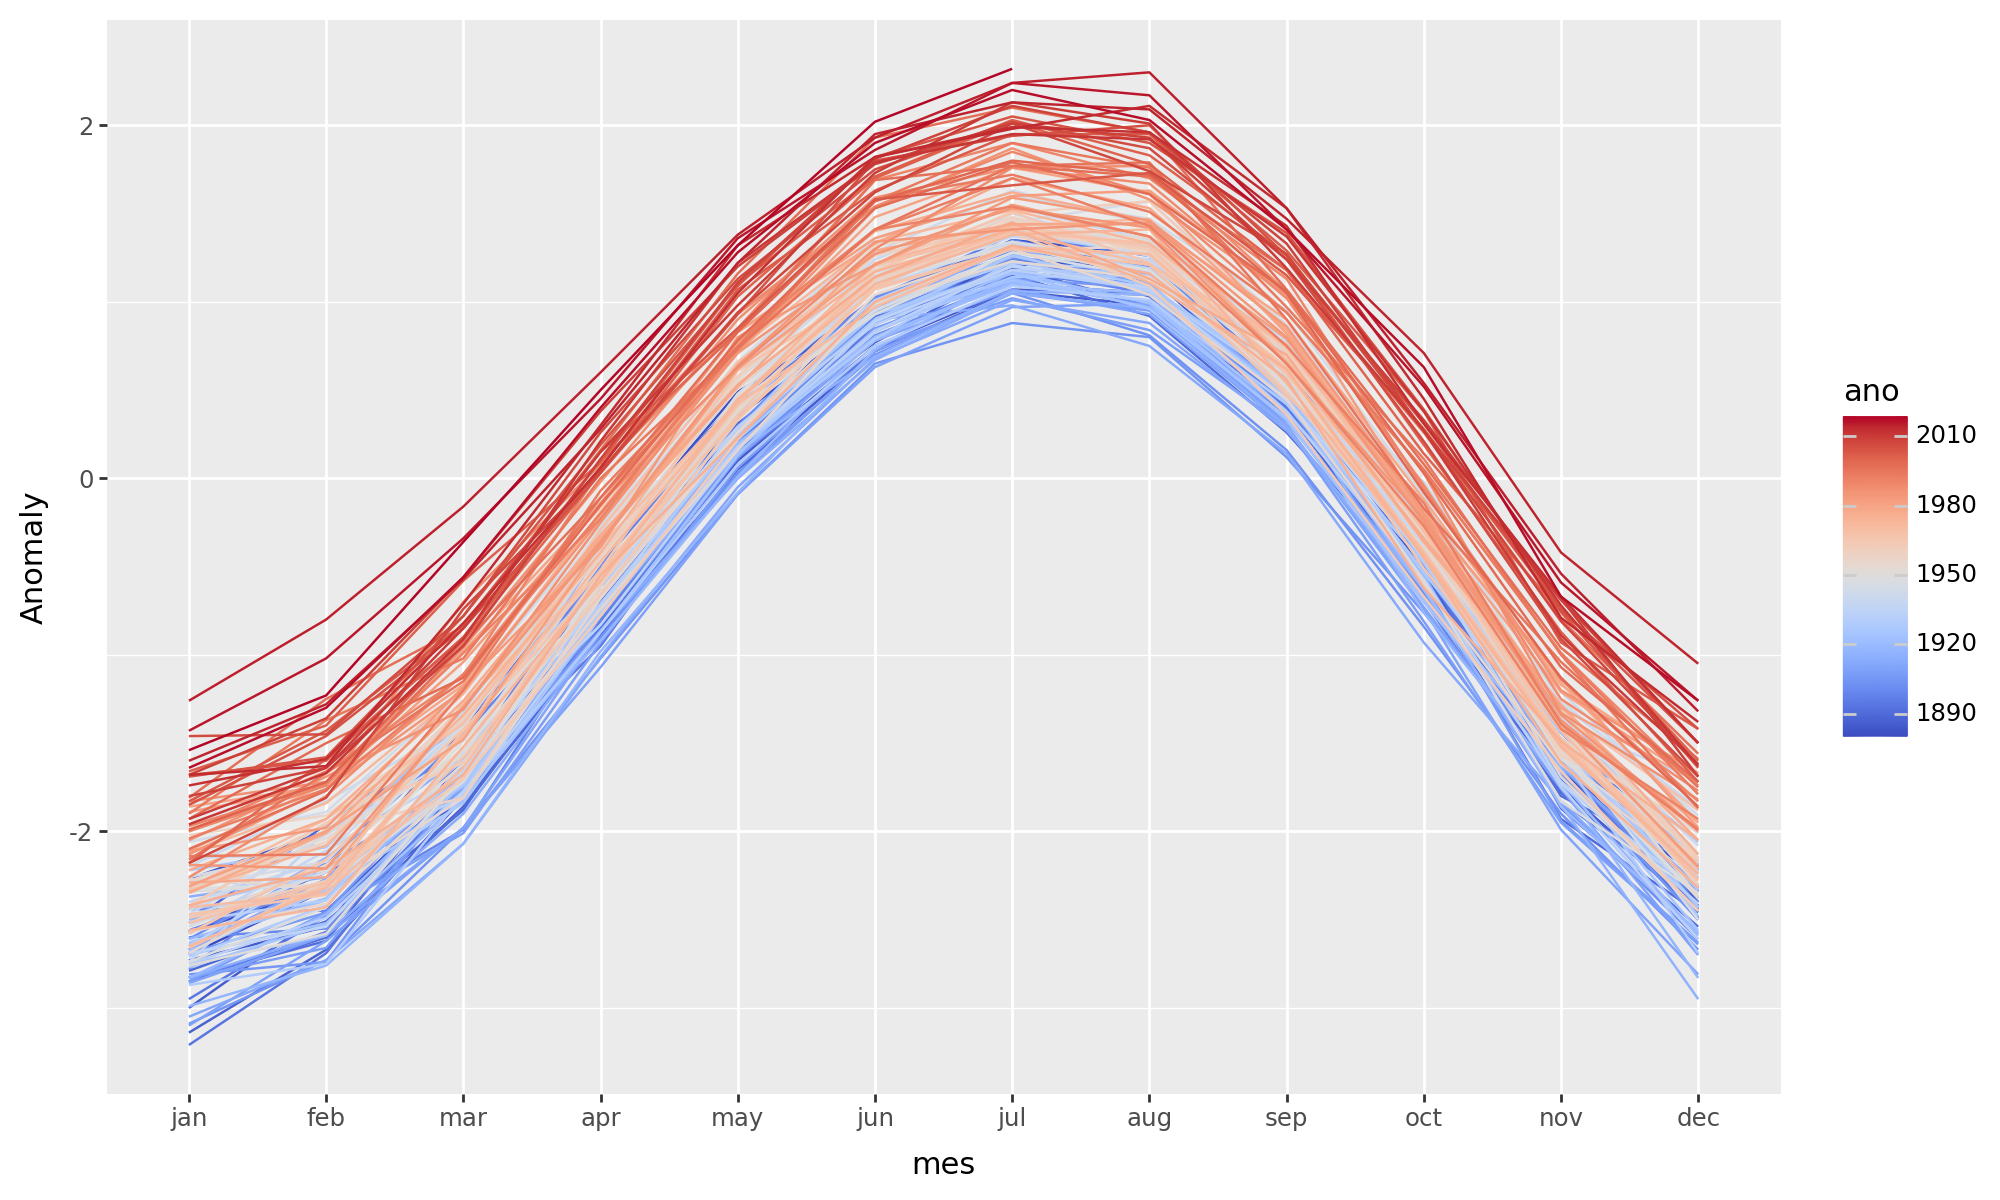

In [91]:
from plotnine import ggplot, aes, geom_line, theme, scale_color_cmap

(ggplot(df, aes(x='mes', y='Anomaly', group='ano', color='ano'))
 + geom_line()
 + scale_color_cmap("coolwarm")
 + theme(figure_size=(10, 6))
)

## Como ajustar a cor de uma categoria, caso você tenha uma mensagem para a sua audiência sobre esta categoria. Exemplo: vamos deixar todos os meses em cinza e o mês de dezembro em azul.

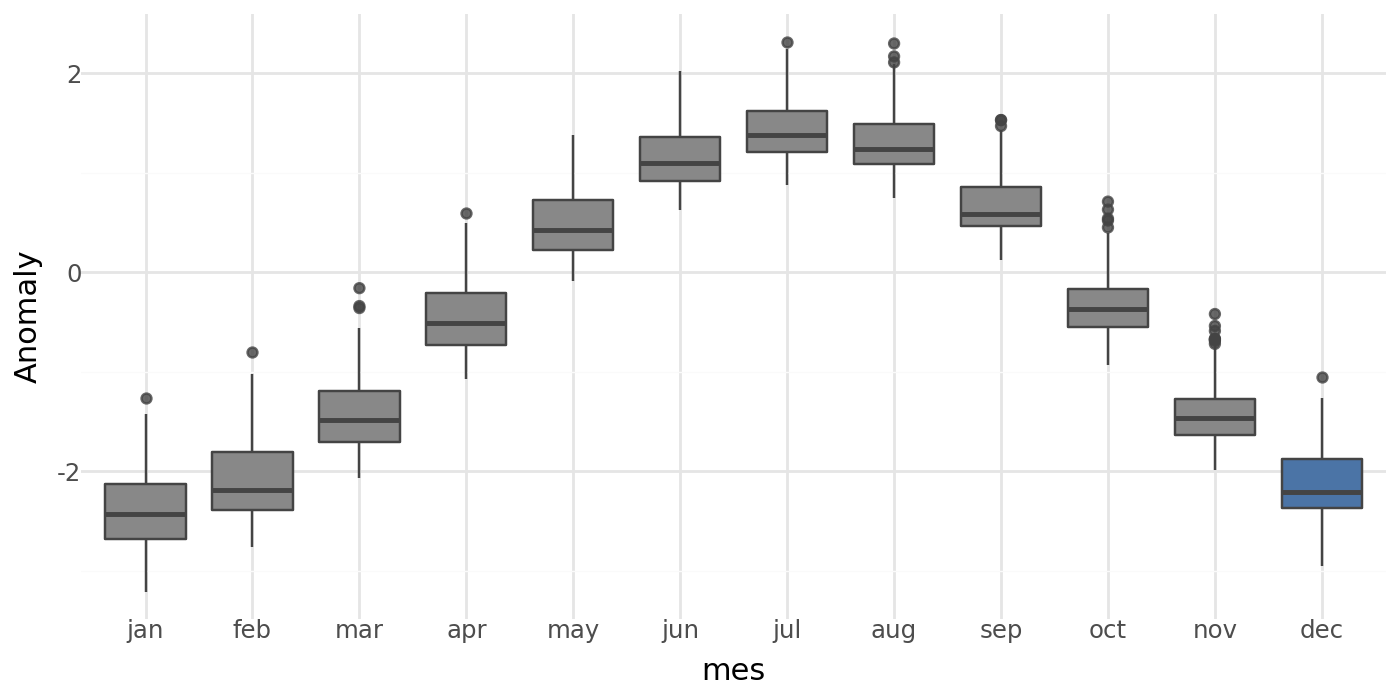

In [112]:
import pandas as pd
from plotnine import ggplot, aes, geom_boxplot, theme_minimal, scale_x_discrete, theme, scale_fill_manual

# Supondo que seu DataFrame se chama df e tem colunas: 'mes' (str ou int) e 'Anomaly' (numérico)
# Se for número, converta para rótulos abreviados em português:
ordem_meses = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
df['mes'] = pd.Categorical(df['mes'], categories=ordem_meses, ordered=True)
df['destaque'] = df['mes'].apply(lambda m: 'dec' if m=='dec' else 'outro')

# Plot
p = (
    ggplot(df, aes(x='mes', y='Anomaly', fill='destaque'))
    + geom_boxplot(color="#444444", outlier_alpha=0.8)
    + scale_fill_manual(values={'dec':'#4B74A6', 'outro':'#888888'})
    + theme_minimal()
    + theme(figure_size=(7,3.5))
    + guides(fill=False)  # Remove legenda do destaque se quiser
)
p